In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import math

#sns.set(rc={'figure.figsize':(11.7,8.27)})

%matplotlib inline

In [2]:
def CategoricalPlots(data, cols, ref='accepted'):
    '''
    Plot categorical data from the DataFrame 'data' using the columns in cols.
    Split the categorical data in line with a label reference
    '''
    if not('dummy' in data.columns):
        data['dummy'] = np.ones(shape = data.shape[0])
    for col in cols:
        print(col)
        counts = data[['dummy', ref, col]].groupby([ref, col], as_index = False).count()
        _ = plt.figure(figsize = (13,4))
        plt.subplot(1, 2, 1)
        temp = counts[counts[ref] == 0][[col, 'dummy']]
        plt.bar(temp[col], temp.dummy)
        plt.xticks(rotation=90)
        plt.title('Counts for ' + col + '\n not accepted')
        plt.ylabel('count')
        plt.subplot(1, 2, 2)
        temp = counts[counts[ref] == 1][[col, 'dummy']]
        plt.bar(temp[col], temp.dummy)
        plt.xticks(rotation=90)
        plt.title('Counts for ' + col + '\n accepted')
        plt.ylabel('count')
        plt.show()

def BoxPlots(data, columns, ref = ['accepted'], hue='accepted'):
    for column in columns:
        for r in ref:
            fig, ax = plt.subplots(figsize=(11.7,8.27))
            sns.boxplot(x=r, ax=ax, y=column, data=data, hue=hue)
            plt.xlabel(r)
            plt.ylabel(column)
            plt.show()
        
def DistPlots(data, columns):
    for column in columns:
        fig, ax = plt.subplots(figsize=(11.7,8.27))
        ax = sns.distplot(data[column], ax=ax)
        plt.xlabel('value')
        plt.ylabel('density')
        plt.title('Histogram of ' + column)
        plt.show()
        
def DistPlotsSplit(data, columns, ref=''):
    '''
    Plot several distributions with a reference column
    '''
    if ref != '':
        unique = data[ref].unique()
    for column in columns:
        if ref != '':
            ax = sns.distplot(data.loc[data[ref]==unique[0], column])
            ax = sns.distplot(data.loc[data[ref]==unique[1], column], ax=ax)
        else:
            ax = sns.distplot(data[column])
        plt.xlabel('value')
        plt.ylabel('density')
        plt.title('Histogram of ' + column)
        plt.show()
    

In [3]:
def ReplaceNaN(data, ref, col, how='mean'):
    '''
    Replacing a NaN value with a random number from a normal distribution.
    Parameter how defines whether the value will be coming from a normal distribution "mean"
    or a simple "median" value of the reference column.
    '''
    if ref == col:
        replace_mean = data[col].mean()
        replace_std = data[col].std()
        replace_value = np.random.normal(loc=replace_mean, scale=replace_std)
        data.loc[(data[col].isnull()), col] = replace_value
    else:
        unique_values = data[ref].unique()
        if unique_values.shape[0] < 500:
            for value in unique_values:
                if how =='mean':
                    replace_mean = data[data[ref]==value][col].mean()
                    replace_std = data[data[ref]==value][col].std()
                    replace_value = np.random.normal(loc=replace_mean, scale=replace_std)
                elif how == 'median':
                    replace_value = data[data[ref]==value][col].median()
                data.loc[(data[ref]==value) & (data[col].isnull()), col] = replace_value               
        else:
            raise('ReplaceNaN: too many unique values to fill')    

from sklearn import preprocessing
            
def encode_category(numeric_category):
    ## First encode the strings to numeric categories
    #enc = preprocessing.LabelEncoder()
    #enc.fit(cat_features)
    #enc_cat_features = enc.transform(cat_features)
    ## Now, apply one hot encoding
    ohe = preprocessing.OneHotEncoder(categories='auto')
    encoded = ohe.fit(numeric_category.values.reshape(-1,1))
    return encoded.transform(numeric_category.values.reshape(-1,1)).toarray()
            
def PrepareFeatures(data, cols):
    '''
    Use one-hot-encoder to encode the categorical features.
    The columns to encode in the dataset are defined by the cols_categorical list
    '''
    features = np.array([])
    for col in cols:
        temp = encode_category(data[col])
        if features.shape[0] == 0:
            features = temp
        else:
            features = np.concatenate([features, temp], axis = 1)
    return features

In [4]:
# first import the training data
train_data = pd.read_csv('train_values.csv', index_col=0)

# then import the lender classification done by a separate data analysis
lender_classification = pd.read_csv('lender_classification.csv', index_col='lender')
train_data['lender_classification'] = train_data['lender'].apply(lambda x: lender_classification.loc[x, 'accept_rate'])

# and then import the state_county classificaiton also done as a separate analysis
state_county_classification = pd.read_csv('state_county_classification.csv', index_col='state_county')
train_data['state_county'] = train_data['state_code'].map(str) + train_data['county_code'].map(str)
train_data['state_county_classification'] = train_data['lender'].apply(lambda x: lender_classification.loc[x, 'accept_rate'])

print(train_data.shape)
train_data.head()

(500000, 24)


,loan_type,property_type,loan_purpose,occupancy,loan_amount,preapproval,msa_md,state_code,county_code,applicant_ethnicity,...,minority_population_pct,ffiecmedian_family_income,tract_to_msa_md_income_pct,number_of_owner-occupied_units,number_of_1_to_4_family_units,lender,co_applicant,lender_classification,state_county,state_county_classification
row_id,,,,,,,,,,,,,,,,,,,,,
0,3,1,1,1,70.0,3,18,37,246,2,...,44.230,60588.0,50.933,716.0,2642.0,4536,False,0.837209,37246,0.837209
1,1,1,3,1,178.0,3,369,52,299,1,...,15.905,54821.0,100.000,1622.0,2108.0,2458,False,0.168919,52299,0.168919
2,2,1,3,1,163.0,3,16,10,306,2,...,61.270,67719.0,100.000,760.0,1048.0,5710,False,0.489632,10306,0.489632
3,1,1,1,1,155.0,1,305,47,180,2,...,6.246,78439.0,100.000,2025.0,2299.0,5888,True,0.691964,47180,0.691964
4,1,1,1,1,305.0,3,24,37,20,2,...,100.000,63075.0,82.200,1464.0,1847.0,289,False,0.542994,3720,0.542994


In [6]:
cols_numerical = ['loan_amount', 'applicant_income', 'number_of_owner-occupied_units', 'number_of_1_to_4_family_units',
                  'ffiecmedian_family_income', 'minority_population_pct', 'tract_to_msa_md_income_pct','population',
                 'lender_classification', 'state_county_classification']
cols_categorical = ['loan_type', 'property_type', 'loan_purpose', 'occupancy', 'preapproval', 
                    'applicant_ethnicity', 'applicant_race', 'applicant_sex','co_applicant']

cols_property_location = ['msa_md', 'state_code', 'county_code']

cols_lender = ['lender']

In [7]:
ReplaceNaN(train_data, 'msa_md', 'applicant_income', how='mean')
train_data['number_of_1_to_4_family_units'].fillna(method='ffill', inplace=True)
train_data['number_of_owner-occupied_units'].fillna(method='ffill', inplace=True)

In [8]:
train_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 500000 entries, 0 to 499999
Data columns (total 24 columns):
loan_type                         500000 non-null int64
property_type                     500000 non-null int64
loan_purpose                      500000 non-null int64
occupancy                         500000 non-null int64
loan_amount                       500000 non-null float64
preapproval                       500000 non-null int64
msa_md                            500000 non-null int64
state_code                        500000 non-null int64
county_code                       500000 non-null int64
applicant_ethnicity               500000 non-null int64
applicant_race                    500000 non-null int64
applicant_sex                     500000 non-null int64
applicant_income                  500000 non-null float64
population                        477535 non-null float64
minority_population_pct           477534 non-null float64
ffiecmedian_family_income         477560 

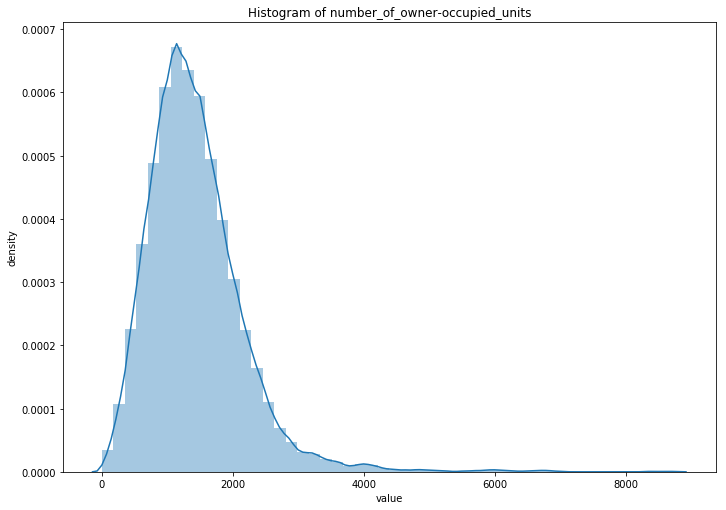

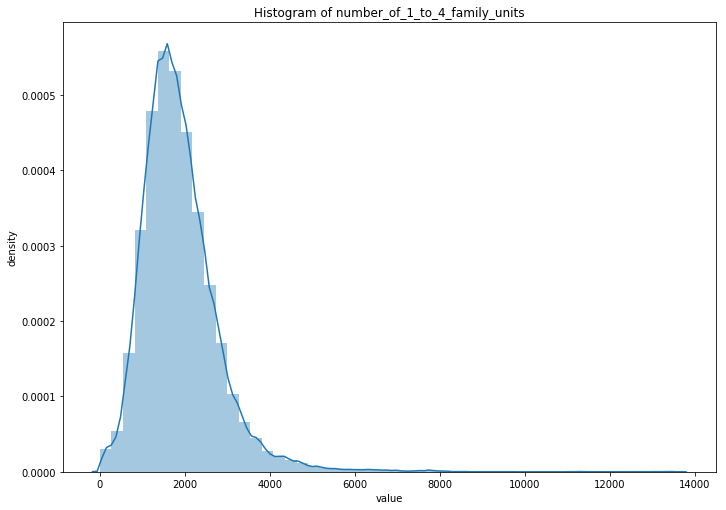

In [9]:
DistPlots(train_data, ['number_of_owner-occupied_units', 'number_of_1_to_4_family_units'])

In [10]:
train_labels = pd.read_csv('train_labels.csv', index_col=0)
data = train_data.merge(train_labels, on='row_id')

In [11]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 500000 entries, 0 to 499999
Data columns (total 25 columns):
loan_type                         500000 non-null int64
property_type                     500000 non-null int64
loan_purpose                      500000 non-null int64
occupancy                         500000 non-null int64
loan_amount                       500000 non-null float64
preapproval                       500000 non-null int64
msa_md                            500000 non-null int64
state_code                        500000 non-null int64
county_code                       500000 non-null int64
applicant_ethnicity               500000 non-null int64
applicant_race                    500000 non-null int64
applicant_sex                     500000 non-null int64
applicant_income                  500000 non-null float64
population                        477535 non-null float64
minority_population_pct           477534 non-null float64
ffiecmedian_family_income         477560 

In [ ]:
# lest just drop all the columns with missing data and see where we get
#data.drop(data[data[['applicant_income']].isna().all(axis=1)].index, inplace=True)
#data.info()

In [ ]:
#BoxPlots(data, cols_numerical, hue='applicant_ethnicity')

In [ ]:
#log_cols_numerical = ['log_' + x for x in cols_numerical]
cols_to_log =  ['loan_amount']
log_cols_numerical = ['log_' + x for x in cols_to_log]

data[log_cols_numerical] = data[cols_to_log].applymap(math.log)

In [ ]:
BoxPlots(data, ['log_loan_amount', 'applicant_income'], hue='lender_size')

# Modeling

In [12]:
from sklearn import preprocessing
import sklearn.model_selection as ms
from sklearn import linear_model
import sklearn.metrics as sklm
import sklearn.ensemble as ensemble
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.naive_bayes import GaussianNB, BernoulliNB
from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn import feature_selection as fs

In [13]:
#if not('lender_size' in cols_categorical):
#    cols_categorical.extend(['lender_size'])
cols_categorical

['loan_type',
 'property_type',
 'loan_purpose',
 'occupancy',
 'preapproval',
 'applicant_ethnicity',
 'applicant_race',
 'applicant_sex',
 'co_applicant']

In [40]:
features = PrepareFeatures(data, cols_categorical)

In [41]:
features.shape

(500000, 33)

In [42]:
features = np.concatenate([features, np.array(data[['loan_amount',
                                                    'applicant_income',
                                                    'lender_classification',
                                                    #'state_county_classification',
                                                   'msa_md',
                                                    #'state_county'
                                                   #'state_code',
                                                   #'county_code',
                                                   #'number_of_owner-occupied_units', 
                                                   # 'number_of_1_to_4_family_units'
                                                   ]])], axis = 1)

In [43]:
X_train, X_test, y_train, y_test = train_test_split(features, data['accepted'], test_size=0.3) # 70% training and 30% test

In [46]:
abc = AdaBoostClassifier(n_estimators=250, learning_rate=0.1)
model_abc = abc.fit(X_train, y_train)
y_pred = model_abc.predict(X_test)
        
print("Accuracy:", metrics.accuracy_score(y_test, y_pred))

Accuracy: 0.7082266666666667


In [45]:
model_abc.feature_importances_

array([0.   , 0.   , 0.   , 0.   , 0.   , 0.   , 0.   , 0.092, 0.008,
       0.   , 0.   , 0.   , 0.   , 0.068, 0.   , 0.   , 0.02 , 0.016,
       0.   , 0.   , 0.   , 0.   , 0.036, 0.   , 0.048, 0.   , 0.016,
       0.   , 0.   , 0.   , 0.02 , 0.02 , 0.016, 0.052, 0.12 , 0.392,
       0.076])

In [ ]:
rfc = RandomForestClassifier(n_estimators=60)
model_rfc = rfc.fit(X_train, y_train)
y_pred = model_rfc.predict(X_test)
        
print("Accuracy:", metrics.accuracy_score(y_test, y_pred))

In [ ]:
lr = linear_model.LogisticRegression(C=10, solver='liblinear') 
model_rl = lr.fit(X_train, y_train)

y_pred = model_rl.predict(X_test)

print("Accuracy:", metrics.accuracy_score(y_test, y_pred))

In [ ]:
etc = ensemble.BaggingClassifier()
model_etc = etc.fit(X_train, y_train)

y_pred = model_etc.predict(X_test)

print("Accuracy:", metrics.accuracy_score(y_test, y_pred))

Test data starts here

In [ ]:
test_data = pd.read_csv('test_values.csv', index_col=0)
print(test_data.shape)
lender_classification = pd.read_csv('lender_classification.csv', index_col='lender')
test_data['lender_classification'] = test_data['lender'].apply(lambda x: lender_classification.loc[x, 'accept_rate']
                                                              if x in lender_classification.index else 0.5)

#test_data['lender_size'] = test_data['lender'].apply(ClassifyLender, args=[test_data['lender'].value_counts()])

ReplaceNaN(test_data, 'msa_md', 'applicant_income', how='mean')
test_data['number_of_1_to_4_family_units'].fillna(method='ffill', inplace=True)
test_data['number_of_owner-occupied_units'].fillna(method='ffill', inplace=True)

test_data.info()

test_features = PrepareFeatures(test_data, cols_categorical)
print(test_features.shape)

test_features = np.concatenate([test_features, np.array(test_data[['loan_amount',
                                                                   'applicant_income',
                                                                   'lender_classification',
                                                                  'msa_md',
                                                               'state_code',
                                                                'county_code',
                                                               'number_of_owner-occupied_units', 
                                                                'number_of_1_to_4_family_units']])], axis = 1)

print(test_features.shape)

y_test_pred = model_rfc.predict(test_features)

In [ ]:
series = pd.Series(y_test_pred)

In [ ]:
series.value_counts()

In [ ]:
test_output = pd.DataFrame(columns=['row_id', 'accepted'])
test_output['accepted'] = series
test_output['row_id'] = test_output.index
test_output= test_output.set_index('row_id')
test_output.head()

In [ ]:
test_output.to_csv('submission-v3.csv')